In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
from functools import lru_cache
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import svm
import warnings

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.exceptions import ConvergenceWarning

In [2]:
@lru_cache(maxsize=None)
def load_heart():
    # https://www.kaggle.com/ronitf/heart-disease-uci
    df = pd.read_csv("data/heart.csv")
    X = df.iloc[:,0:-1]
    y = df.iloc[:,-1]
    return X, y

In [3]:
@lru_cache(maxsize=None)
def load_mobile():
    # https://www.kaggle.com/iabhishekofficial/mobile-price-classification
    df = pd.read_csv("data/phone_price.csv")
    print(df['price_range'])
    X = df.iloc[:,0:-1]
    y = df.iloc[:,-1]
    return X, y

In [4]:
@lru_cache(maxsize=None)
def load_adult():
    df = pd.read_csv("data/adult.csv")
    df = pd.get_dummies(df)
    df = df.drop(df.columns[-2], axis=1)
    X = df.iloc[:,0:-1]
    y = df.iloc[:,-1]
    return X, y

In [5]:
@lru_cache(maxsize=None)
def load_weather():
    # https://www.kaggle.com/jsphyg/weather-dataset-rattle-package?select=weatherAUS.csv
    df = pd.read_csv("data/weather.csv")
    df = df.dropna(axis=0)
    df = pd.get_dummies(df, dummy_na=False)
    # drop the nan column
    df = df.drop(df.columns[-1], axis=1)
    # drop the no column
    df = df.drop(df.columns[-2], axis=1)
    X = df.iloc[:,0:-1]
    y = df.iloc[:,-1]
    return X, y


In [12]:
# X, y = load_heart()
X, y = load_mobile()
# X, y = load_adult()
# X, y = load_weather()

0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range, Length: 2000, dtype: int64


# Understanding the Data

In [16]:
def save_figs(dX, y, name):
    plt.matshow(X.corr())
    plt.yticks(np.arange(X.shape[1]), X.columns)
    plt.xticks(np.arange(X.shape[1]), X.columns)
    plt.colorbar()
    plt.savefig(f'{name}_correlation.png', bbox_inches='tight')
    plt.clf()
    X.hist()
    plt.savefig(f'{name}_histogram.png', bbox_inches='tight')
    plt.clf()
    y.hist()
    plt.savefig(f'{name}_y_histogram.png', bbox_inches='tight')
    plt.clf()
# save_figs(X,y,"weather")

# Decision Tree

(1600, 20)
(2000, 20)


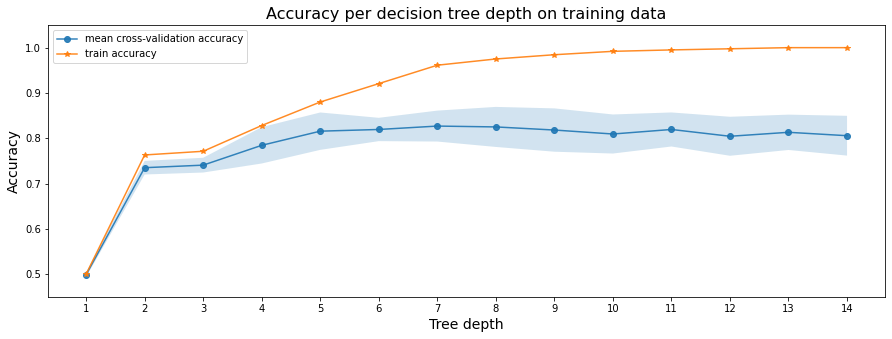

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=12)
print(x_train.shape)
print(X.shape)
# function for fitting trees of various depths on the training data using cross-validation
# Referenced via https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        fitted = tree_model.fit(X, y)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(fitted.score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim(0.45,1.05)
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,15)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(x_train, y_train, sm_tree_depths)

# plotting accuracy\
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

# Empty array that will hold our classifiers
classifiers = []

# MLP (Neural Network)

In [38]:
!python3 -m pip install yellowbrick
from yellowbrick.model_selection import LearningCurve
# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

for label, param in zip(labels,params):
    print("training: %s" % label)
    mlp = MLPClassifier(random_state=0,
                        max_iter=400, **param)

    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning,
                                module="sklearn")
        mlp.fit(x_train, y_train)
#     print("Training set score: %f" % mlp.score(x_train, y_train))
#     print("Training set loss: %f" % mlp.loss_)
#     print("Test set score: %f" % mlp.score(x_test,y_test))

train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(mlp,x_train, y_train,
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",
         label="SVR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()


You should consider upgrading via the '/Users/nathan.brake/gatech/ml/ml-env/bin/python3 -m pip install --upgrade pip' command.


ModuleNotFoundError: No module named 'yellowbrick'

# Supervised Learning Algorithms 

In [21]:
classifiers = [
    (DecisionTreeClassifier(max_depth=5), "Decision Tree"),
    (MLPClassifier(), "Neural Network"),
    (AdaBoostClassifier(), "Boost"),
    (svm.SVC(), "SVM"),
    (KNeighborsClassifier(3), "KNN")
]
kfold = KFold(10, shuffle=True, random_state=1)
for train_index, test_index in kfold.split(X):
    for clf in classifiers:
        x_train, x_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = clf[0].fit(x_train, y_train)
        accuracy = model.score(x_test, y_test)
        print(clf[1])
        print("accuracy: {0:.3f}%".format(accuracy))


Decision Tree
accuracy: 0.755%
Neural Network
accuracy: 0.650%
Boost
accuracy: 0.665%
SVM
accuracy: 0.925%
KNN
accuracy: 0.905%
Decision Tree
accuracy: 0.810%
Neural Network
accuracy: 0.655%
Boost
accuracy: 0.695%
SVM
accuracy: 0.965%
KNN
accuracy: 0.910%
Decision Tree
accuracy: 0.795%
Neural Network
accuracy: 0.665%
Boost
accuracy: 0.685%
SVM
accuracy: 0.950%
KNN
accuracy: 0.935%
Decision Tree
accuracy: 0.810%
Neural Network
accuracy: 0.650%
Boost
accuracy: 0.685%
SVM
accuracy: 0.945%
KNN
accuracy: 0.910%
Decision Tree
accuracy: 0.795%
Neural Network
accuracy: 0.595%
Boost
accuracy: 0.805%
SVM
accuracy: 0.950%
KNN
accuracy: 0.910%
Decision Tree
accuracy: 0.845%
Neural Network
accuracy: 0.610%
Boost
accuracy: 0.800%
SVM
accuracy: 0.960%
KNN
accuracy: 0.915%
Decision Tree
accuracy: 0.875%
Neural Network
accuracy: 0.625%
Boost
accuracy: 0.820%
SVM
accuracy: 0.980%
KNN
accuracy: 0.945%
Decision Tree
accuracy: 0.840%
Neural Network
accuracy: 0.695%
Boost
accuracy: 0.800%
SVM
accuracy: 0.94